# Imports

In [1]:
from pathlib import Path

import IPython
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from einops import asnumpy, parse_shape, rearrange, reduce
from einops.layers.torch import Rearrange
import librosa

rng = np.random.default_rng()

# Functions

In [2]:
F1 = np.array([697, 770, 852, 941])
F2 = np.array([1209, 1336, 1477, 1633])
tones = {
    "1": (0, 0),
    "2": (0, 1),
    "3": (0, 2),
    "4": (1, 0),
    "5": (1, 1),
    "6": (1, 2),
    "7": (2, 0),
    "8": (2, 1),
    "9": (2, 2),
    "0": (3, 1),
    "*": (3, 0),
    "#": (3, 2),
    "A": (0, 3),
    "B": (1, 3),
    "C": (2, 3),
    "D": (3, 3),
}
SYMBOLS = list("1234567890*#ABCD")
FS = 22_050  # Hz

In [5]:

translate_dict = dict(zip(SYMBOLS, range(len(SYMBOLS))))

def tone(symbol, duration, fs):
    """Generate the sound for symbol with given duration and sampling frequency"""
    inds = tones[symbol]
    f1 = F1[inds[0]]
    f2 = F2[inds[1]]  # get both frequencies for the digit

    t = np.arange(0, duration, 1 / fs)
    return np.cos(2 * np.pi * f1 * t) + np.cos(2 * np.pi * f2 * t)  # calculate signal

def generate_dataset(n_symbols: int=10):
    """
    Generate a dataset of DTMF signals.

    Parameters:
    n_symbols (int): Number of symbols to generate in the dataset.

    Returns:
    list_of_segments (list): List of generated signal segments.
    list_of_symbols (list): List of symbols corresponding to the generated signals.
    """
    list_of_symbols = rng.choice(SYMBOLS, size=n_symbols)
    list_of_segments = list()

    duration = 2048  # samples
    for symbol in list_of_symbols:
        # generate tone
        signal = tone(symbol=symbol, duration=duration / FS, fs=FS)
        # generate silence
        silence = np.zeros(duration)
        # append tone and silence
        list_of_segments.append(signal)

    return list_of_segments, list_of_symbols.tolist()

In [3]:
def plot_waveform(waveform, sr):
    """
    Plot the waveform of an audio signal.

    Parameters:
    waveform (torch.Tensor): The waveform to plot.
    sr (int): The sample rate of the waveform.
    title (str, optional): The title of the plot. Defaults to "Waveform".
    """

    num_frames, = waveform.shape
    time_axis = np.arange(0, num_frames) / sr
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(time_axis, waveform)

## Generate training and testing sets

In [6]:
N_DATA = 100

X_train, y_train = generate_dataset(N_DATA)
X_test, y_test = generate_dataset(N_DATA)

## Display and listen

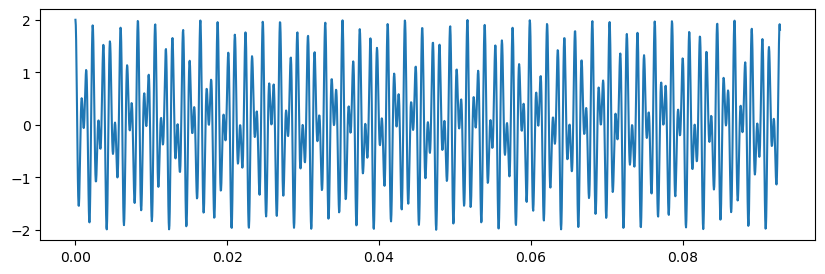

In [7]:
ind = 2
label = y_train[ind]
plot_waveform(waveform=X_train[ind], sr=FS)

In [8]:
IPython.display.Audio(X_train[ind], rate=FS)